<a href="https://colab.research.google.com/github/Priyaljain20/Mitosis-Count/blob/main/cyclegan_mitosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Dropout, concatenate, InputLayer, MaxPooling2D, UpSampling2D,BatchNormalization,Add,Activation
from tensorflow.keras.models import Model
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Dataset prepration#

In [ ]:
import tensorflow_datasets as tfds
dataset, metadata = tfds.load('cycle_gan/apple2orange',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteVL6XZ8/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteVL6XZ8/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteVL6XZ8/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteVL6XZ8/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH_x = 256
IMG_HEIGHT_X = 256
IMG_WIDTH_y = 256
IMG_HEIGHT_y = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_x(image, label):
  #image = random_jitter(image)

  image = tf.image.resize(image, [128, 128],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = normalize(image)
  return image

def preprocess_image_y(image, label):
  
  image = tf.image.resize(image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = normalize(image)
  return image


In [ ]:

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_horses = train_horses.map(
    preprocess_image_x, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_y, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_x, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_y, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

Text(0.5, 1.0, 'Horse with random jitter')

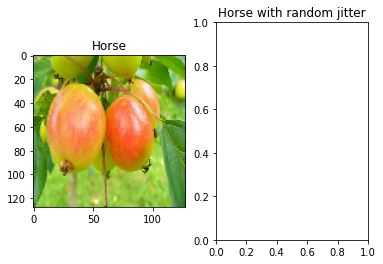

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
#plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

Text(0.5, 1.0, 'Zebra with random jitter')

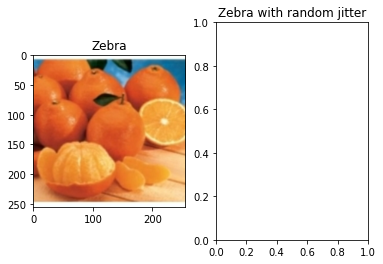

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
#plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

#Model building#

In [ ]:
def identity_block(X,activation,padding,kernel_size,filters):
    X_skip=X
    X=Conv2D(filters,kernel_size,activation=activation,padding=padding,kernel_initializer='he_uniform')(X)
    X=BatchNormalization()(X)
    X=Conv2D(filters,kernel_size,activation=activation,padding=padding,kernel_initializer='he_uniform')(X)
    X=BatchNormalization()(X)
    X_skip=Conv2D(filters,1,activation=activation,padding=padding,kernel_initializer='he_uniform')(X_skip)
    X= Add()([X,X_skip])
    X=Activation(activation)(X)
    return X

In [ ]:
#building res2unet model 

def build_generator_kmit_to_icpr14():
    
    input_size=(128,128,3)
    inputs=tf.keras.Input(shape=input_size)
    
    conv1=identity_block(inputs,'relu','same',3,32)
    pool1=MaxPool2D(pool_size=(2,2))(conv1)
    
    conv2=identity_block(pool1,'relu','same',3,64)
    pool2=MaxPool2D(pool_size=(2,2))(conv2)
    
    conv3=identity_block(pool2,'relu','same',3,128)
    pool3=MaxPool2D(pool_size=(2,2))(conv3)
    
    conv4=identity_block(pool3,'relu','same',3,256)
    pool4=MaxPool2D(pool_size=(2,2))(conv4)
    
    conv5=identity_block(pool4,'relu','same',3,512)
    
    convtranspose4=Conv2DTranspose(512,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(conv5)
    concatenate4=concatenate([convtranspose4,conv4],axis=3)
    convrev4= identity_block(concatenate4,'relu','same',3,256)
    
    convtranspose3=Conv2DTranspose(256,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev4)
    concatenate3=concatenate([convtranspose3,conv3],axis=3)
    convrev3= identity_block(concatenate3,'relu','same',3,128)
    
    convtranspose2=Conv2DTranspose(128,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev3)
    concatenate2=concatenate([convtranspose2,conv2],axis=3)
    convrev2= identity_block(concatenate2,'relu','same',3,64)
    
    convtranspose1=Conv2DTranspose(64,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev2)
    concatenate1=concatenate([convtranspose1,conv1],axis=3)
    convrev1= identity_block(concatenate1,'relu','same',3,32)
    
    convtranspose0=Conv2DTranspose(64,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev1)
    convrev0= identity_block(convtranspose0,'relu','same',3,16)
    
    outputs= Conv2D(3,1,activation='sigmoid')(convrev0)
    
    model=Model(inputs=inputs,outputs=outputs)
    
    print(model.summary())
    return model

In [ ]:
#building res2unet model 

def build_generator_icpr14_to_kmit():
    
    input_size=(256,256,3)
    inputs=tf.keras.Input(shape=input_size)
    
    conv0=identity_block(inputs,'relu','same',3,16)
    pool0=MaxPool2D(pool_size=(2,2))(conv0)
    
    conv1=identity_block(pool0,'relu','same',3,32)
    pool1=MaxPool2D(pool_size=(2,2))(conv1)
    
    conv2=identity_block(pool1,'relu','same',3,64)
    pool2=MaxPool2D(pool_size=(2,2))(conv2)
    
    conv3=identity_block(pool2,'relu','same',3,128)
    pool3=MaxPool2D(pool_size=(2,2))(conv3)
    
    conv4=identity_block(pool3,'relu','same',3,256)
    pool4=MaxPool2D(pool_size=(2,2))(conv4)
    
    conv5=identity_block(pool4,'relu','same',3,512)
    
    convtranspose4=Conv2DTranspose(512,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(conv5)
    concatenate4=concatenate([convtranspose4,conv4],axis=3)
    convrev4= identity_block(concatenate4,'relu','same',3,256)
    
    convtranspose3=Conv2DTranspose(256,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev4)
    concatenate3=concatenate([convtranspose3,conv3],axis=3)
    convrev3= identity_block(concatenate3,'relu','same',3,128)
    
    convtranspose2=Conv2DTranspose(128,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev3)
    concatenate2=concatenate([convtranspose2,conv2],axis=3)
    convrev2= identity_block(concatenate2,'relu','same',3,64)
    
    convtranspose1=Conv2DTranspose(64,2,strides=(2,2),activation='relu',padding='same',kernel_initializer='he_uniform')(convrev2)
    concatenate1=concatenate([convtranspose1,conv1],axis=3)
    convrev1= identity_block(concatenate1,'relu','same',3,32)
    
    
    outputs= Conv2D(3,1,activation='sigmoid')(convrev1)
    
    model=Model(inputs=inputs,outputs=outputs)
    
    print(model.summary())
    return model

In [ ]:
generator_g=build_generator_kmit_to_icpr14()
generator_f=build_generator_icpr14_to_kmit()
type(generator_g)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        batch_normalization[0][0]        
_______________________________________________________________________________________

tensorflow.python.keras.engine.functional.Functional

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-6_1xik7b
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-6_1xik7b
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0e7a63baa06c0afd133a98eee95457533b7f9dc1_-cp36-none-any.whl size=157025 sha256=ad491b8fd55ebb4eeb192c6f7949a188ab88f53d694857b00b97fa4d7caf40bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-5qp4sykv/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
def discriminator_icpr14():
    
    input_size=(256,256,3)
    
    model=tf.keras.applications.VGG16(
        include_top=False, weights=None, input_tensor=None, input_shape=input_size,
        pooling=None, classes=1, classifier_activation='softmax')
    return model

In [ ]:
def discriminator_kmit():
    
    input_size=(128,128,3)
    
    model=tf.keras.applications.VGG16(
        include_top=False, weights=None, input_tensor=None, input_shape=input_size,
        pooling=None, classes=1, classifier_activation='softmax')
    return model

In [ ]:
discriminator_x=discriminator_kmit()
discriminator_y=discriminator_icpr14()
type(discriminator_x.summary())
type(discriminator_y.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

NoneType

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    ##print("hi1")
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    ##print("hi2")
    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    #print("hi3")
    # same_x and same_y are used for identity loss.
    #same_x = generator_f(real_x, training=True)
    #same_y = generator_g(real_y, training=True)

    ##print("hi3")
    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    ##print("hi4")
    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    ##print(disc_real_x," ",disc_real_y)
    ##print(disc_fake_x," ",disc_fake_y)

    ##print("hi5")
    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    ##print("hi6")
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    ##print("hi7")
    ##print(gen_g_loss)
    ##print("--------",total_cycle_loss)
    #print("realy",real_y)
    #print("samey",same_y)
    #print("---------",identity_loss(real_y,same_y))
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss #+ identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss #+ identity_loss(real_x, same_x)

    ##print("hi8")
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  ##print("hi9")
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [37]:
from tqdm import tqdm
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tqdm(tf.data.Dataset.zip((train_horses, train_zebras))):
    
    #shape
    #print(image_x.shape,generator_g(image_x).shape,generator_f(generator_g(image_x)).shape)
    #print(discriminator_x(image_x).shape,discriminator_y(generator_g(image_x)).shape,discriminator_x(generator_f(generator_g(image_x))).shape)
    
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))






  0%|          | 0/995 [00:00<?, ?it/s]




  0%|          | 1/995 [00:09<2:35:26,  9.38s/it]

.






  0%|          | 2/995 [00:18<2:34:57,  9.36s/it]




  0%|          | 3/995 [00:27<2:34:28,  9.34s/it]




  0%|          | 4/995 [00:37<2:34:10,  9.33s/it]




  1%|          | 5/995 [00:46<2:33:52,  9.33s/it]




  1%|          | 6/995 [00:55<2:33:52,  9.34s/it]




  1%|          | 7/995 [01:05<2:33:55,  9.35s/it]




  1%|          | 8/995 [01:14<2:33:39,  9.34s/it]




  1%|          | 9/995 [01:24<2:33:35,  9.35s/it]




  1%|          | 10/995 [01:33<2:33:23,  9.34s/it]




  1%|          | 11/995 [01:42<2:33:20,  9.35s/it]

.






  1%|          | 12/995 [01:52<2:33:09,  9.35s/it]




  1%|▏         | 13/995 [02:01<2:32:49,  9.34s/it]




  1%|▏         | 14/995 [02:10<2:32:31,  9.33s/it]




  2%|▏         | 15/995 [02:19<2:32:05,  9.31s/it]




  2%|▏         | 16/995 [02:29<2:31:51,  9.31s/it]




  2%|▏         | 17/995 [02:38<2:31:49,  9.31s/it]




  2%|▏         | 18/995 [02:47<2:31:41,  9.32s/it]




  2%|▏         | 19/995 [02:57<2:31:18,  9.30s/it]




  2%|▏         | 20/995 [03:06<2:31:01,  9.29s/it]




  2%|▏         | 21/995 [03:15<2:30:52,  9.29s/it]

.






  2%|▏         | 22/995 [03:25<2:30:42,  9.29s/it]




  2%|▏         | 23/995 [03:34<2:30:21,  9.28s/it]




  2%|▏         | 24/995 [03:43<2:30:19,  9.29s/it]




  3%|▎         | 25/995 [03:52<2:30:17,  9.30s/it]




  3%|▎         | 26/995 [04:02<2:30:07,  9.30s/it]




  3%|▎         | 27/995 [04:11<2:30:07,  9.31s/it]




  3%|▎         | 28/995 [04:20<2:29:59,  9.31s/it]




  3%|▎         | 29/995 [04:30<2:29:45,  9.30s/it]




  3%|▎         | 30/995 [04:39<2:30:00,  9.33s/it]




  3%|▎         | 31/995 [04:48<2:29:54,  9.33s/it]

.






  3%|▎         | 32/995 [04:58<2:29:30,  9.32s/it]




  3%|▎         | 33/995 [05:07<2:29:13,  9.31s/it]




  3%|▎         | 34/995 [05:16<2:28:53,  9.30s/it]




  4%|▎         | 35/995 [05:25<2:28:36,  9.29s/it]




  4%|▎         | 36/995 [05:35<2:28:27,  9.29s/it]




  4%|▎         | 37/995 [05:44<2:28:04,  9.27s/it]




  4%|▍         | 38/995 [05:53<2:27:52,  9.27s/it]




  4%|▍         | 39/995 [06:03<2:27:44,  9.27s/it]




  4%|▍         | 40/995 [06:12<2:27:43,  9.28s/it]




  4%|▍         | 41/995 [06:21<2:27:49,  9.30s/it]

.






  4%|▍         | 42/995 [06:30<2:27:31,  9.29s/it]




  4%|▍         | 43/995 [06:40<2:27:26,  9.29s/it]




  4%|▍         | 44/995 [06:49<2:27:22,  9.30s/it]




  5%|▍         | 45/995 [06:58<2:27:12,  9.30s/it]




  5%|▍         | 46/995 [07:08<2:27:07,  9.30s/it]




  5%|▍         | 47/995 [07:17<2:27:01,  9.31s/it]




  5%|▍         | 48/995 [07:26<2:27:09,  9.32s/it]




  5%|▍         | 49/995 [07:36<2:27:07,  9.33s/it]




  5%|▌         | 50/995 [07:45<2:27:12,  9.35s/it]




  5%|▌         | 51/995 [07:54<2:26:47,  9.33s/it]

.






  5%|▌         | 52/995 [08:04<2:26:06,  9.30s/it]




  5%|▌         | 53/995 [08:13<2:26:02,  9.30s/it]




  5%|▌         | 54/995 [08:22<2:25:52,  9.30s/it]




  6%|▌         | 55/995 [08:32<2:25:46,  9.30s/it]




  6%|▌         | 56/995 [08:41<2:25:43,  9.31s/it]




  6%|▌         | 57/995 [08:50<2:25:45,  9.32s/it]




  6%|▌         | 58/995 [09:00<2:25:35,  9.32s/it]




  6%|▌         | 59/995 [09:09<2:25:24,  9.32s/it]




  6%|▌         | 60/995 [09:18<2:25:17,  9.32s/it]




  6%|▌         | 61/995 [09:28<2:25:21,  9.34s/it]

.






  6%|▌         | 62/995 [09:37<2:24:57,  9.32s/it]




  6%|▋         | 63/995 [09:46<2:25:00,  9.33s/it]




  6%|▋         | 64/995 [09:56<2:24:46,  9.33s/it]




  7%|▋         | 65/995 [10:05<2:24:56,  9.35s/it]




  7%|▋         | 66/995 [10:14<2:24:42,  9.35s/it]




  7%|▋         | 67/995 [10:24<2:24:26,  9.34s/it]




  7%|▋         | 68/995 [10:33<2:24:07,  9.33s/it]




  7%|▋         | 69/995 [10:42<2:23:42,  9.31s/it]




  7%|▋         | 70/995 [10:51<2:23:32,  9.31s/it]




  7%|▋         | 71/995 [11:01<2:23:19,  9.31s/it]

.






  7%|▋         | 72/995 [11:10<2:23:15,  9.31s/it]




  7%|▋         | 73/995 [11:19<2:23:06,  9.31s/it]




  7%|▋         | 74/995 [11:29<2:23:08,  9.33s/it]




  8%|▊         | 75/995 [11:38<2:23:01,  9.33s/it]




  8%|▊         | 76/995 [11:47<2:22:32,  9.31s/it]




  8%|▊         | 77/995 [11:57<2:22:12,  9.29s/it]




  8%|▊         | 78/995 [12:06<2:21:59,  9.29s/it]




  8%|▊         | 79/995 [12:15<2:21:55,  9.30s/it]




  8%|▊         | 80/995 [12:25<2:21:55,  9.31s/it]




  8%|▊         | 81/995 [12:34<2:21:46,  9.31s/it]

.






  8%|▊         | 82/995 [12:43<2:21:44,  9.31s/it]




  8%|▊         | 83/995 [12:52<2:21:33,  9.31s/it]




  8%|▊         | 84/995 [13:02<2:21:26,  9.32s/it]




  9%|▊         | 85/995 [13:11<2:21:22,  9.32s/it]




  9%|▊         | 86/995 [13:20<2:21:16,  9.33s/it]




  9%|▊         | 87/995 [13:30<2:21:07,  9.33s/it]




  9%|▉         | 88/995 [13:39<2:20:48,  9.31s/it]




  9%|▉         | 89/995 [13:48<2:20:44,  9.32s/it]




  9%|▉         | 90/995 [13:58<2:20:22,  9.31s/it]




  9%|▉         | 91/995 [14:07<2:20:21,  9.32s/it]

.






  9%|▉         | 92/995 [14:16<2:20:08,  9.31s/it]




  9%|▉         | 93/995 [14:26<2:20:03,  9.32s/it]




  9%|▉         | 94/995 [14:35<2:19:54,  9.32s/it]




 10%|▉         | 95/995 [14:44<2:19:47,  9.32s/it]




 10%|▉         | 96/995 [14:54<2:19:32,  9.31s/it]




 10%|▉         | 97/995 [15:03<2:19:11,  9.30s/it]




 10%|▉         | 98/995 [15:12<2:19:14,  9.31s/it]




 10%|▉         | 99/995 [15:22<2:19:19,  9.33s/it]




 10%|█         | 100/995 [15:31<2:18:50,  9.31s/it]




 10%|█         | 101/995 [15:40<2:18:50,  9.32s/it]

.






 10%|█         | 102/995 [15:49<2:18:37,  9.31s/it]




 10%|█         | 103/995 [15:59<2:18:32,  9.32s/it]




 10%|█         | 104/995 [16:08<2:18:09,  9.30s/it]




 11%|█         | 105/995 [16:17<2:18:05,  9.31s/it]




 11%|█         | 106/995 [16:27<2:18:11,  9.33s/it]




 11%|█         | 107/995 [16:36<2:18:04,  9.33s/it]




 11%|█         | 108/995 [16:45<2:17:56,  9.33s/it]




 11%|█         | 109/995 [16:55<2:17:59,  9.35s/it]




 11%|█         | 110/995 [17:04<2:17:58,  9.35s/it]




 11%|█         | 111/995 [17:16<2:27:22, 10.00s/it]

.






 11%|█▏        | 112/995 [17:25<2:24:05,  9.79s/it]




 11%|█▏        | 113/995 [17:34<2:21:53,  9.65s/it]




 11%|█▏        | 114/995 [17:44<2:20:12,  9.55s/it]




 12%|█▏        | 115/995 [17:53<2:19:11,  9.49s/it]




 12%|█▏        | 116/995 [18:02<2:18:22,  9.45s/it]




 12%|█▏        | 117/995 [18:12<2:17:24,  9.39s/it]




 12%|█▏        | 118/995 [18:21<2:16:59,  9.37s/it]




 12%|█▏        | 119/995 [18:30<2:16:40,  9.36s/it]




 12%|█▏        | 120/995 [18:40<2:16:15,  9.34s/it]




 12%|█▏        | 121/995 [18:49<2:16:06,  9.34s/it]

.






 12%|█▏        | 122/995 [18:58<2:15:50,  9.34s/it]




 12%|█▏        | 123/995 [19:08<2:15:32,  9.33s/it]




 12%|█▏        | 124/995 [19:17<2:15:17,  9.32s/it]




 13%|█▎        | 125/995 [19:26<2:14:59,  9.31s/it]




 13%|█▎        | 126/995 [19:35<2:14:54,  9.31s/it]




 13%|█▎        | 127/995 [19:45<2:14:54,  9.33s/it]




 13%|█▎        | 128/995 [19:54<2:14:39,  9.32s/it]




 13%|█▎        | 129/995 [20:03<2:14:19,  9.31s/it]




 13%|█▎        | 130/995 [20:13<2:14:03,  9.30s/it]




 13%|█▎        | 131/995 [20:22<2:13:51,  9.30s/it]

.






 13%|█▎        | 132/995 [20:31<2:13:38,  9.29s/it]




 13%|█▎        | 133/995 [20:41<2:13:46,  9.31s/it]




 13%|█▎        | 134/995 [20:50<2:13:43,  9.32s/it]




 14%|█▎        | 135/995 [20:59<2:13:38,  9.32s/it]




 14%|█▎        | 136/995 [21:09<2:13:34,  9.33s/it]




 14%|█▍        | 137/995 [21:18<2:13:30,  9.34s/it]




 14%|█▍        | 138/995 [21:27<2:13:19,  9.33s/it]




 14%|█▍        | 139/995 [21:37<2:13:09,  9.33s/it]




 14%|█▍        | 140/995 [21:46<2:13:08,  9.34s/it]




 14%|█▍        | 141/995 [21:55<2:13:06,  9.35s/it]

.






 14%|█▍        | 142/995 [22:05<2:12:57,  9.35s/it]




 14%|█▍        | 143/995 [22:14<2:12:22,  9.32s/it]




 14%|█▍        | 144/995 [22:23<2:12:10,  9.32s/it]




 15%|█▍        | 145/995 [22:33<2:11:58,  9.32s/it]




 15%|█▍        | 146/995 [22:42<2:11:45,  9.31s/it]




 15%|█▍        | 147/995 [22:51<2:11:20,  9.29s/it]




 15%|█▍        | 148/995 [23:00<2:11:12,  9.29s/it]




 15%|█▍        | 149/995 [23:10<2:11:12,  9.31s/it]




 15%|█▌        | 150/995 [23:19<2:11:12,  9.32s/it]




 15%|█▌        | 151/995 [23:28<2:11:06,  9.32s/it]

.






 15%|█▌        | 152/995 [23:38<2:10:53,  9.32s/it]




 15%|█▌        | 153/995 [23:47<2:10:44,  9.32s/it]




 15%|█▌        | 154/995 [23:56<2:10:29,  9.31s/it]




 16%|█▌        | 155/995 [24:06<2:10:10,  9.30s/it]




 16%|█▌        | 156/995 [24:15<2:10:21,  9.32s/it]




 16%|█▌        | 157/995 [24:24<2:10:07,  9.32s/it]




 16%|█▌        | 158/995 [24:34<2:09:40,  9.30s/it]




 16%|█▌        | 159/995 [24:43<2:09:39,  9.31s/it]




 16%|█▌        | 160/995 [24:52<2:09:34,  9.31s/it]




 16%|█▌        | 161/995 [25:02<2:09:24,  9.31s/it]

.






 16%|█▋        | 162/995 [25:11<2:09:16,  9.31s/it]




 16%|█▋        | 163/995 [25:20<2:08:56,  9.30s/it]




 16%|█▋        | 164/995 [25:29<2:08:44,  9.30s/it]




 17%|█▋        | 165/995 [25:39<2:08:33,  9.29s/it]




 17%|█▋        | 166/995 [25:48<2:08:22,  9.29s/it]




 17%|█▋        | 167/995 [25:57<2:08:11,  9.29s/it]




 17%|█▋        | 168/995 [26:06<2:07:54,  9.28s/it]




 17%|█▋        | 169/995 [26:16<2:07:47,  9.28s/it]




 17%|█▋        | 170/995 [26:25<2:07:46,  9.29s/it]




 17%|█▋        | 171/995 [26:34<2:07:35,  9.29s/it]

.






 17%|█▋        | 172/995 [26:44<2:07:29,  9.30s/it]




 17%|█▋        | 173/995 [26:53<2:07:11,  9.28s/it]




 17%|█▋        | 174/995 [27:02<2:07:10,  9.29s/it]




 18%|█▊        | 175/995 [27:12<2:07:11,  9.31s/it]




 18%|█▊        | 176/995 [27:23<2:16:09,  9.97s/it]




 18%|█▊        | 177/995 [27:33<2:16:59, 10.05s/it]




 18%|█▊        | 178/995 [27:43<2:13:46,  9.82s/it]




 18%|█▊        | 179/995 [27:52<2:11:23,  9.66s/it]




 18%|█▊        | 180/995 [28:01<2:09:49,  9.56s/it]




 18%|█▊        | 181/995 [28:11<2:08:58,  9.51s/it]

.






 18%|█▊        | 182/995 [28:20<2:08:10,  9.46s/it]




 18%|█▊        | 183/995 [28:29<2:07:21,  9.41s/it]




 18%|█▊        | 184/995 [28:39<2:06:41,  9.37s/it]




 19%|█▊        | 185/995 [28:48<2:06:24,  9.36s/it]




 19%|█▊        | 186/995 [28:57<2:06:07,  9.35s/it]




 19%|█▉        | 187/995 [29:07<2:05:46,  9.34s/it]




 19%|█▉        | 188/995 [29:16<2:05:21,  9.32s/it]




 19%|█▉        | 189/995 [29:25<2:05:08,  9.32s/it]




 19%|█▉        | 190/995 [29:34<2:05:02,  9.32s/it]




 19%|█▉        | 191/995 [29:44<2:04:44,  9.31s/it]

.






 19%|█▉        | 192/995 [29:53<2:04:34,  9.31s/it]




 19%|█▉        | 193/995 [30:02<2:04:11,  9.29s/it]




 19%|█▉        | 194/995 [30:12<2:04:05,  9.30s/it]




 20%|█▉        | 195/995 [30:21<2:03:58,  9.30s/it]




 20%|█▉        | 196/995 [30:30<2:03:58,  9.31s/it]




 20%|█▉        | 197/995 [30:40<2:03:42,  9.30s/it]




 20%|█▉        | 198/995 [30:49<2:03:37,  9.31s/it]




 20%|██        | 199/995 [30:58<2:03:35,  9.32s/it]




 20%|██        | 200/995 [31:08<2:03:34,  9.33s/it]




 20%|██        | 201/995 [31:17<2:03:32,  9.34s/it]

.






 20%|██        | 202/995 [31:26<2:03:23,  9.34s/it]




 20%|██        | 203/995 [31:36<2:03:07,  9.33s/it]




 21%|██        | 204/995 [31:45<2:02:39,  9.30s/it]




 21%|██        | 205/995 [31:54<2:02:31,  9.31s/it]




 21%|██        | 206/995 [32:03<2:02:22,  9.31s/it]




 21%|██        | 207/995 [32:13<2:02:08,  9.30s/it]




 21%|██        | 208/995 [32:22<2:02:17,  9.32s/it]




 21%|██        | 209/995 [32:31<2:02:09,  9.33s/it]




 21%|██        | 210/995 [32:41<2:01:57,  9.32s/it]




 21%|██        | 211/995 [32:50<2:01:42,  9.31s/it]

.






 21%|██▏       | 212/995 [32:59<2:01:34,  9.32s/it]




 21%|██▏       | 213/995 [33:09<2:01:22,  9.31s/it]




 22%|██▏       | 214/995 [33:18<2:01:17,  9.32s/it]




 22%|██▏       | 215/995 [33:27<2:01:11,  9.32s/it]




 22%|██▏       | 216/995 [33:37<2:01:05,  9.33s/it]




 22%|██▏       | 217/995 [33:46<2:00:52,  9.32s/it]




 22%|██▏       | 218/995 [33:55<2:00:46,  9.33s/it]




 22%|██▏       | 219/995 [34:05<2:00:36,  9.33s/it]




 22%|██▏       | 220/995 [34:14<2:00:23,  9.32s/it]




 22%|██▏       | 221/995 [34:23<2:00:21,  9.33s/it]

.






 22%|██▏       | 222/995 [34:33<2:00:04,  9.32s/it]




 22%|██▏       | 223/995 [34:42<1:59:51,  9.32s/it]




 23%|██▎       | 224/995 [34:51<2:00:16,  9.36s/it]




 23%|██▎       | 225/995 [35:01<1:59:58,  9.35s/it]




 23%|██▎       | 226/995 [35:10<1:59:42,  9.34s/it]




 23%|██▎       | 227/995 [35:19<1:59:31,  9.34s/it]




 23%|██▎       | 228/995 [35:29<1:59:05,  9.32s/it]




 23%|██▎       | 229/995 [35:38<1:59:03,  9.33s/it]




 23%|██▎       | 230/995 [35:47<1:58:53,  9.32s/it]




 23%|██▎       | 231/995 [35:57<1:58:54,  9.34s/it]

.






 23%|██▎       | 232/995 [36:06<1:58:46,  9.34s/it]




 23%|██▎       | 233/995 [36:15<1:58:24,  9.32s/it]




 24%|██▎       | 234/995 [36:25<1:58:14,  9.32s/it]




 24%|██▎       | 235/995 [36:34<1:58:16,  9.34s/it]




 24%|██▎       | 236/995 [36:43<1:58:08,  9.34s/it]




 24%|██▍       | 237/995 [36:53<1:58:13,  9.36s/it]




 24%|██▍       | 238/995 [37:02<1:57:57,  9.35s/it]




 24%|██▍       | 239/995 [37:11<1:57:23,  9.32s/it]




 24%|██▍       | 240/995 [37:21<1:57:20,  9.32s/it]




 24%|██▍       | 241/995 [37:31<2:02:31,  9.75s/it]

.






 24%|██▍       | 242/995 [37:42<2:04:29,  9.92s/it]




 24%|██▍       | 243/995 [37:51<2:02:10,  9.75s/it]




 25%|██▍       | 244/995 [38:00<2:00:31,  9.63s/it]




 25%|██▍       | 245/995 [38:10<1:59:23,  9.55s/it]




 25%|██▍       | 246/995 [38:19<1:58:26,  9.49s/it]




 25%|██▍       | 247/995 [38:28<1:57:40,  9.44s/it]




 25%|██▍       | 248/995 [38:38<1:57:04,  9.40s/it]




 25%|██▌       | 249/995 [38:47<1:56:41,  9.39s/it]




 25%|██▌       | 250/995 [38:56<1:56:11,  9.36s/it]




 25%|██▌       | 251/995 [39:06<1:55:49,  9.34s/it]

.






 25%|██▌       | 252/995 [39:15<1:55:32,  9.33s/it]




 25%|██▌       | 253/995 [39:24<1:55:33,  9.34s/it]




 26%|██▌       | 254/995 [39:34<1:55:12,  9.33s/it]




 26%|██▌       | 255/995 [39:43<1:54:52,  9.31s/it]




 26%|██▌       | 256/995 [39:52<1:54:49,  9.32s/it]




 26%|██▌       | 257/995 [40:02<1:54:47,  9.33s/it]




 26%|██▌       | 258/995 [40:11<1:54:35,  9.33s/it]




 26%|██▌       | 259/995 [40:20<1:54:22,  9.32s/it]




 26%|██▌       | 260/995 [40:30<1:54:14,  9.33s/it]




 26%|██▌       | 261/995 [40:39<1:54:13,  9.34s/it]

.






 26%|██▋       | 262/995 [40:48<1:53:59,  9.33s/it]




 26%|██▋       | 263/995 [40:58<1:53:39,  9.32s/it]




 27%|██▋       | 264/995 [41:07<1:53:27,  9.31s/it]




 27%|██▋       | 265/995 [41:16<1:53:14,  9.31s/it]




 27%|██▋       | 266/995 [41:25<1:53:10,  9.32s/it]




 27%|██▋       | 267/995 [41:35<1:52:52,  9.30s/it]




 27%|██▋       | 268/995 [41:44<1:52:34,  9.29s/it]




 27%|██▋       | 269/995 [41:53<1:52:25,  9.29s/it]




 27%|██▋       | 270/995 [42:03<1:52:17,  9.29s/it]




 27%|██▋       | 271/995 [42:12<1:52:11,  9.30s/it]

.






 27%|██▋       | 272/995 [42:21<1:52:11,  9.31s/it]




 27%|██▋       | 273/995 [42:31<1:52:11,  9.32s/it]




 28%|██▊       | 274/995 [42:40<1:52:03,  9.32s/it]




 28%|██▊       | 275/995 [42:49<1:51:47,  9.32s/it]




 28%|██▊       | 276/995 [42:59<1:51:45,  9.33s/it]




 28%|██▊       | 277/995 [43:08<1:51:27,  9.31s/it]




 28%|██▊       | 278/995 [43:17<1:51:22,  9.32s/it]




 28%|██▊       | 279/995 [43:26<1:51:08,  9.31s/it]




 28%|██▊       | 280/995 [43:36<1:51:12,  9.33s/it]




 28%|██▊       | 281/995 [43:45<1:51:12,  9.35s/it]

.






 28%|██▊       | 282/995 [43:55<1:50:59,  9.34s/it]




 28%|██▊       | 283/995 [44:04<1:50:37,  9.32s/it]




 29%|██▊       | 284/995 [44:13<1:50:23,  9.32s/it]




 29%|██▊       | 285/995 [44:22<1:50:13,  9.31s/it]




 29%|██▊       | 286/995 [44:32<1:50:12,  9.33s/it]




 29%|██▉       | 287/995 [44:41<1:50:02,  9.32s/it]




 29%|██▉       | 288/995 [44:50<1:49:33,  9.30s/it]




 29%|██▉       | 289/995 [45:00<1:49:36,  9.31s/it]




 29%|██▉       | 290/995 [45:09<1:49:40,  9.33s/it]




 29%|██▉       | 291/995 [45:18<1:49:20,  9.32s/it]

.






 29%|██▉       | 292/995 [45:28<1:49:07,  9.31s/it]




 29%|██▉       | 293/995 [45:37<1:48:57,  9.31s/it]




 30%|██▉       | 294/995 [45:46<1:48:45,  9.31s/it]




 30%|██▉       | 295/995 [45:56<1:48:22,  9.29s/it]




 30%|██▉       | 296/995 [46:05<1:48:18,  9.30s/it]




 30%|██▉       | 297/995 [46:14<1:47:52,  9.27s/it]




 30%|██▉       | 298/995 [46:23<1:47:58,  9.30s/it]




 30%|███       | 299/995 [46:33<1:47:54,  9.30s/it]




 30%|███       | 300/995 [46:42<1:47:46,  9.30s/it]




 30%|███       | 301/995 [46:51<1:47:34,  9.30s/it]

.






 30%|███       | 302/995 [47:01<1:47:27,  9.30s/it]




 30%|███       | 303/995 [47:10<1:47:18,  9.30s/it]




 31%|███       | 304/995 [47:19<1:47:09,  9.30s/it]




 31%|███       | 305/995 [47:29<1:47:03,  9.31s/it]




 31%|███       | 306/995 [47:38<1:46:55,  9.31s/it]




 31%|███       | 307/995 [47:47<1:46:46,  9.31s/it]




 31%|███       | 308/995 [47:56<1:46:32,  9.31s/it]




 31%|███       | 309/995 [48:06<1:46:31,  9.32s/it]




 31%|███       | 310/995 [48:15<1:46:32,  9.33s/it]




 31%|███▏      | 311/995 [48:24<1:46:11,  9.32s/it]

.






 31%|███▏      | 312/995 [48:34<1:46:03,  9.32s/it]




 31%|███▏      | 313/995 [48:43<1:46:11,  9.34s/it]




 32%|███▏      | 314/995 [48:53<1:46:10,  9.35s/it]




 32%|███▏      | 315/995 [49:02<1:46:01,  9.36s/it]




 32%|███▏      | 316/995 [49:11<1:45:38,  9.34s/it]




 32%|███▏      | 317/995 [49:21<1:45:24,  9.33s/it]




 32%|███▏      | 318/995 [49:30<1:45:19,  9.33s/it]




 32%|███▏      | 319/995 [49:39<1:44:55,  9.31s/it]




 32%|███▏      | 320/995 [49:48<1:44:46,  9.31s/it]




 32%|███▏      | 321/995 [49:58<1:44:34,  9.31s/it]

.






 32%|███▏      | 322/995 [50:07<1:44:20,  9.30s/it]




 32%|███▏      | 323/995 [50:16<1:44:17,  9.31s/it]




 33%|███▎      | 324/995 [50:26<1:43:54,  9.29s/it]




 33%|███▎      | 325/995 [50:35<1:43:44,  9.29s/it]




 33%|███▎      | 326/995 [50:44<1:43:45,  9.31s/it]




 33%|███▎      | 327/995 [50:54<1:43:44,  9.32s/it]




 33%|███▎      | 328/995 [51:03<1:43:38,  9.32s/it]




 33%|███▎      | 329/995 [51:12<1:43:31,  9.33s/it]




 33%|███▎      | 330/995 [51:22<1:43:22,  9.33s/it]




 33%|███▎      | 331/995 [51:31<1:43:21,  9.34s/it]

.






 33%|███▎      | 332/995 [51:40<1:43:09,  9.34s/it]




 33%|███▎      | 333/995 [51:50<1:42:51,  9.32s/it]




 34%|███▎      | 334/995 [51:59<1:42:53,  9.34s/it]




 34%|███▎      | 335/995 [52:08<1:42:39,  9.33s/it]




 34%|███▍      | 336/995 [52:18<1:42:20,  9.32s/it]




 34%|███▍      | 337/995 [52:27<1:42:10,  9.32s/it]




 34%|███▍      | 338/995 [52:36<1:41:59,  9.31s/it]




 34%|███▍      | 339/995 [52:46<1:42:02,  9.33s/it]




 34%|███▍      | 340/995 [52:55<1:41:50,  9.33s/it]




 34%|███▍      | 341/995 [53:04<1:41:34,  9.32s/it]

.






 34%|███▍      | 342/995 [53:14<1:41:36,  9.34s/it]




 34%|███▍      | 343/995 [53:23<1:41:35,  9.35s/it]




 35%|███▍      | 344/995 [53:32<1:41:16,  9.33s/it]




 35%|███▍      | 345/995 [53:42<1:41:01,  9.32s/it]




 35%|███▍      | 346/995 [53:51<1:40:41,  9.31s/it]




 35%|███▍      | 347/995 [54:00<1:40:36,  9.32s/it]




 35%|███▍      | 348/995 [54:09<1:40:25,  9.31s/it]




 35%|███▌      | 349/995 [54:19<1:40:12,  9.31s/it]




 35%|███▌      | 350/995 [54:28<1:40:11,  9.32s/it]




 35%|███▌      | 351/995 [54:37<1:40:10,  9.33s/it]

.






 35%|███▌      | 352/995 [54:47<1:39:47,  9.31s/it]




 35%|███▌      | 353/995 [54:56<1:39:41,  9.32s/it]




 36%|███▌      | 354/995 [55:05<1:39:37,  9.33s/it]




 36%|███▌      | 355/995 [55:15<1:39:29,  9.33s/it]




 36%|███▌      | 356/995 [55:24<1:39:15,  9.32s/it]




 36%|███▌      | 357/995 [55:33<1:39:03,  9.32s/it]




 36%|███▌      | 358/995 [55:43<1:38:38,  9.29s/it]




 36%|███▌      | 359/995 [55:52<1:38:42,  9.31s/it]




 36%|███▌      | 360/995 [56:01<1:38:40,  9.32s/it]




 36%|███▋      | 361/995 [56:11<1:38:34,  9.33s/it]

.






 36%|███▋      | 362/995 [56:20<1:38:37,  9.35s/it]




 36%|███▋      | 363/995 [56:29<1:38:21,  9.34s/it]




 37%|███▋      | 364/995 [56:39<1:37:55,  9.31s/it]




 37%|███▋      | 365/995 [56:48<1:37:35,  9.29s/it]




 37%|███▋      | 366/995 [56:57<1:37:28,  9.30s/it]




 37%|███▋      | 367/995 [57:06<1:37:21,  9.30s/it]




 37%|███▋      | 368/995 [57:16<1:37:25,  9.32s/it]




 37%|███▋      | 369/995 [57:25<1:37:13,  9.32s/it]




 37%|███▋      | 370/995 [57:34<1:36:55,  9.30s/it]




 37%|███▋      | 371/995 [57:44<1:36:35,  9.29s/it]

.






 37%|███▋      | 372/995 [57:53<1:36:24,  9.29s/it]




 37%|███▋      | 373/995 [58:02<1:36:30,  9.31s/it]




 38%|███▊      | 374/995 [58:12<1:36:17,  9.30s/it]




 38%|███▊      | 375/995 [58:21<1:36:00,  9.29s/it]




 38%|███▊      | 376/995 [58:30<1:35:51,  9.29s/it]




 38%|███▊      | 377/995 [58:39<1:35:44,  9.29s/it]




 38%|███▊      | 378/995 [58:49<1:35:36,  9.30s/it]




 38%|███▊      | 379/995 [58:58<1:35:25,  9.30s/it]




 38%|███▊      | 380/995 [59:07<1:35:22,  9.30s/it]




 38%|███▊      | 381/995 [59:17<1:35:09,  9.30s/it]

.






 38%|███▊      | 382/995 [59:26<1:34:49,  9.28s/it]




 38%|███▊      | 383/995 [59:35<1:34:44,  9.29s/it]




 39%|███▊      | 384/995 [59:44<1:34:37,  9.29s/it]




 39%|███▊      | 385/995 [59:54<1:34:20,  9.28s/it]




 39%|███▉      | 386/995 [1:00:03<1:34:14,  9.29s/it]




 39%|███▉      | 387/995 [1:00:12<1:34:07,  9.29s/it]




 39%|███▉      | 388/995 [1:00:22<1:33:58,  9.29s/it]




 39%|███▉      | 389/995 [1:00:31<1:33:55,  9.30s/it]




 39%|███▉      | 390/995 [1:00:40<1:33:42,  9.29s/it]




 39%|███▉      | 391/995 [1:00:49<1:33:28,  9.29s/it]

.






 39%|███▉      | 392/995 [1:00:59<1:33:25,  9.30s/it]




 39%|███▉      | 393/995 [1:01:08<1:33:13,  9.29s/it]




 40%|███▉      | 394/995 [1:01:17<1:33:10,  9.30s/it]




 40%|███▉      | 395/995 [1:01:27<1:32:56,  9.29s/it]




 40%|███▉      | 396/995 [1:01:36<1:32:48,  9.30s/it]




 40%|███▉      | 397/995 [1:01:45<1:32:32,  9.28s/it]




 40%|████      | 398/995 [1:01:55<1:32:23,  9.29s/it]




 40%|████      | 399/995 [1:02:04<1:32:08,  9.28s/it]




 40%|████      | 400/995 [1:02:13<1:32:05,  9.29s/it]




 40%|████      | 401/995 [1:02:22<1:31:54,  9.28s/it]

.






 40%|████      | 402/995 [1:02:32<1:31:52,  9.30s/it]




 41%|████      | 403/995 [1:02:41<1:31:42,  9.30s/it]




 41%|████      | 404/995 [1:02:50<1:31:29,  9.29s/it]




 41%|████      | 405/995 [1:03:00<1:31:22,  9.29s/it]




 41%|████      | 406/995 [1:03:09<1:31:12,  9.29s/it]




 41%|████      | 407/995 [1:03:18<1:31:05,  9.29s/it]




 41%|████      | 408/995 [1:03:27<1:30:58,  9.30s/it]




 41%|████      | 409/995 [1:03:37<1:30:48,  9.30s/it]




 41%|████      | 410/995 [1:03:46<1:30:44,  9.31s/it]




 41%|████▏     | 411/995 [1:03:55<1:30:38,  9.31s/it]

.






 41%|████▏     | 412/995 [1:04:05<1:30:35,  9.32s/it]




 42%|████▏     | 413/995 [1:04:14<1:30:44,  9.36s/it]




 42%|████▏     | 414/995 [1:04:24<1:30:30,  9.35s/it]




 42%|████▏     | 415/995 [1:04:33<1:30:23,  9.35s/it]




 42%|████▏     | 416/995 [1:04:42<1:30:14,  9.35s/it]




 42%|████▏     | 417/995 [1:04:52<1:29:49,  9.32s/it]




 42%|████▏     | 418/995 [1:05:01<1:29:36,  9.32s/it]




 42%|████▏     | 419/995 [1:05:10<1:29:32,  9.33s/it]




 42%|████▏     | 420/995 [1:05:20<1:29:29,  9.34s/it]




 42%|████▏     | 421/995 [1:05:29<1:29:12,  9.33s/it]

.






 42%|████▏     | 422/995 [1:05:38<1:29:02,  9.32s/it]




 43%|████▎     | 423/995 [1:05:47<1:28:50,  9.32s/it]




 43%|████▎     | 424/995 [1:05:57<1:28:30,  9.30s/it]




 43%|████▎     | 425/995 [1:06:06<1:28:17,  9.29s/it]




 43%|████▎     | 426/995 [1:06:15<1:28:07,  9.29s/it]




 43%|████▎     | 427/995 [1:06:25<1:27:57,  9.29s/it]




 43%|████▎     | 428/995 [1:06:34<1:27:53,  9.30s/it]




 43%|████▎     | 429/995 [1:06:43<1:27:46,  9.31s/it]




 43%|████▎     | 430/995 [1:06:53<1:27:39,  9.31s/it]




 43%|████▎     | 431/995 [1:07:02<1:27:34,  9.32s/it]

.






 43%|████▎     | 432/995 [1:07:11<1:27:26,  9.32s/it]




 44%|████▎     | 433/995 [1:07:20<1:27:11,  9.31s/it]




 44%|████▎     | 434/995 [1:07:30<1:27:01,  9.31s/it]




 44%|████▎     | 435/995 [1:07:39<1:26:58,  9.32s/it]




 44%|████▍     | 436/995 [1:07:48<1:26:46,  9.31s/it]




 44%|████▍     | 437/995 [1:07:58<1:26:29,  9.30s/it]




 44%|████▍     | 438/995 [1:08:07<1:26:19,  9.30s/it]




 44%|████▍     | 439/995 [1:08:16<1:26:02,  9.29s/it]




 44%|████▍     | 440/995 [1:08:26<1:26:10,  9.32s/it]




 44%|████▍     | 441/995 [1:08:35<1:26:01,  9.32s/it]

.






 44%|████▍     | 442/995 [1:08:44<1:25:42,  9.30s/it]




 45%|████▍     | 443/995 [1:08:54<1:25:44,  9.32s/it]




 45%|████▍     | 444/995 [1:09:03<1:25:43,  9.33s/it]




 45%|████▍     | 445/995 [1:09:12<1:25:27,  9.32s/it]




 45%|████▍     | 446/995 [1:09:22<1:25:18,  9.32s/it]




 45%|████▍     | 447/995 [1:09:31<1:25:06,  9.32s/it]




 45%|████▌     | 448/995 [1:09:40<1:24:49,  9.30s/it]




 45%|████▌     | 449/995 [1:09:49<1:24:34,  9.29s/it]




 45%|████▌     | 450/995 [1:09:59<1:24:24,  9.29s/it]




 45%|████▌     | 451/995 [1:10:08<1:24:14,  9.29s/it]

.






 45%|████▌     | 452/995 [1:10:17<1:24:06,  9.29s/it]




 46%|████▌     | 453/995 [1:10:27<1:24:11,  9.32s/it]




 46%|████▌     | 454/995 [1:10:36<1:24:00,  9.32s/it]




 46%|████▌     | 455/995 [1:10:45<1:23:48,  9.31s/it]




 46%|████▌     | 456/995 [1:10:55<1:23:43,  9.32s/it]




 46%|████▌     | 457/995 [1:11:04<1:23:34,  9.32s/it]




 46%|████▌     | 458/995 [1:11:13<1:23:26,  9.32s/it]




 46%|████▌     | 459/995 [1:11:23<1:23:23,  9.34s/it]




 46%|████▌     | 460/995 [1:11:32<1:23:15,  9.34s/it]




 46%|████▋     | 461/995 [1:11:41<1:23:03,  9.33s/it]

.






 46%|████▋     | 462/995 [1:11:51<1:22:56,  9.34s/it]




 47%|████▋     | 463/995 [1:12:00<1:22:40,  9.32s/it]




 47%|████▋     | 464/995 [1:12:09<1:22:25,  9.31s/it]




 47%|████▋     | 465/995 [1:12:18<1:22:09,  9.30s/it]




 47%|████▋     | 466/995 [1:12:28<1:22:12,  9.32s/it]




 47%|████▋     | 467/995 [1:12:37<1:22:13,  9.34s/it]




 47%|████▋     | 468/995 [1:12:47<1:21:57,  9.33s/it]




 47%|████▋     | 469/995 [1:12:56<1:21:58,  9.35s/it]




 47%|████▋     | 470/995 [1:13:05<1:21:49,  9.35s/it]




 47%|████▋     | 471/995 [1:13:15<1:21:45,  9.36s/it]

.






 47%|████▋     | 472/995 [1:13:24<1:21:32,  9.35s/it]




 48%|████▊     | 473/995 [1:13:33<1:21:21,  9.35s/it]




 48%|████▊     | 474/995 [1:13:43<1:21:09,  9.35s/it]




 48%|████▊     | 475/995 [1:13:52<1:20:56,  9.34s/it]

KeyboardInterrupt: ignored

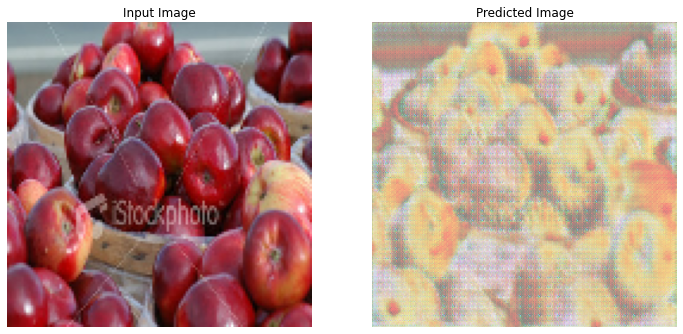

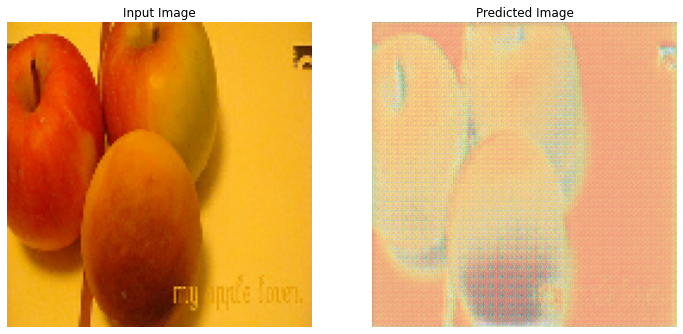

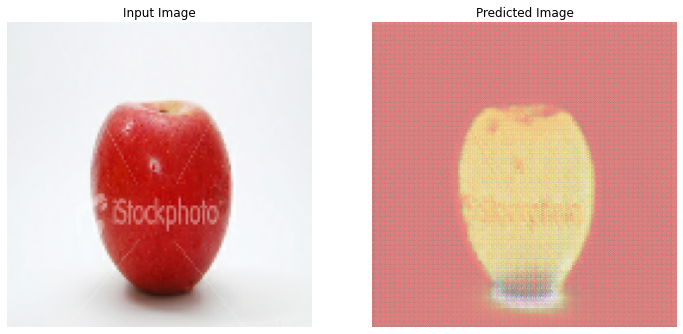

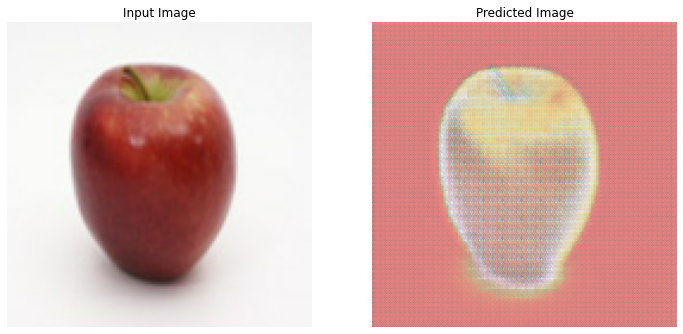

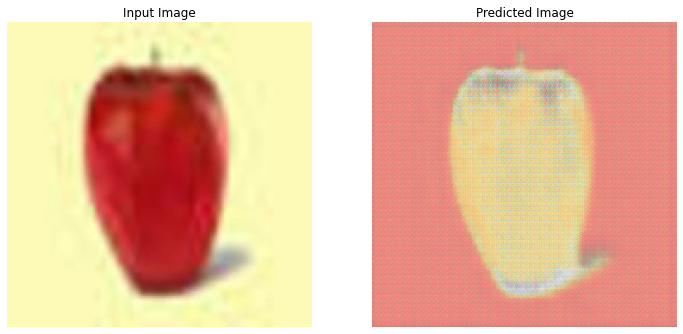

In [38]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)